In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scipy
from adjustText import adjust_text
from datetime import datetime
import sys
import os

paper_path = os.path.dirname(os.getcwd())#"/mnt/x/Common/Lab_Papers/shedding_potential/"
utils_path = paper_path + "/utils/"
PROJ_MAIN_FOLDER = paper_path+"/fig3/"
busslingers_data_path = paper_path + "/external_datasets/busslinger/"
export_path = PROJ_MAIN_FOLDER + "busslinger_ugi/"

os.chdir(utils_path)
import shed_funcs
import matplotlib.patheffects as PathEffects
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

np.random.seed(0)

LOAD_ARIAL = True
if LOAD_ARIAL:
    # set the default font to Arial
    from matplotlib.font_manager import FontProperties, fontManager
    from matplotlib import rcParams
    # Path to Arial font
    arial_path = utils_path+'/Arial.ttf'

    # Define font properties with the specific path
    arial_font = FontProperties(fname=arial_path)
    fontManager.addfont(arial_path)

    # Set the font as the default for all text elements
    rcParams['font.family'] = arial_font.get_family()
    rcParams['font.sans-serif'] = [arial_font.get_name()]

    print("scanpy " + str(sc.__version__))
    print("pandas " + str(pd.__version__))
    print("numpy " + str(np.__version__))
    print("scipy " + str(scipy.__version__))

scanpy 1.11.2
pandas 2.3.0
numpy 2.2.6
scipy 1.15.3


In [2]:
# PLEASE NOTE: The following supplementary tables were defined as datasets during the revision process.

dataset_ev1_name = "Dataset_EV1_NGT_counts.csv" # previously TableS2_NGT_counts.csv
dataset_ev2_name = "Dataset_EV2_pt_metadata.csv" # previously TableS3_pt_metadata.csv
dataset_ev3_name = "Dataset_EV3_markers_df.csv" # previously TableS4_markers_df.csv

# Load and process Busslinger 2021

In [3]:
adata = sc.read_csv(busslingers_data_path+"data_CellReports.tsv",delimiter="\t").T
adata_orig = adata.copy()
adata

AnnData object with n_obs × n_vars = 7680 × 20991

In [4]:
adata = adata_orig.copy()
# remove chromosome info from gene_name
first_elements = []
for sub_list in adata.var_names.str.split("__"):
    first_elements.append(sub_list[0])
adata.var_names = first_elements
adata.var_names_make_unique()

In [5]:
# add metadata - sample geography
sample_anatomy = pd.read_csv(busslingers_data_path+"data_CellReports_human_abb.txt",delimiter="\t")
anatomy_dict = {"ESO": "esophagus", "Cardia": "stomach", "Corpus": "stomach", "Pylorus": "stomach", "SI-Crypt": "duodenum", "SI-Villi": "duodenum"}
organ_tissue_dict = {"ESO": "esophagus", "Cardia": "stomach_cardia", "Corpus": "stomach_corpus", "Pylorus": "stomach_pylorus", "SI-Crypt": "duodenum_crypt", "SI-Villi": "duodenum_villi"}
organ_tissue_duo_dict = {"ESO": "esophagus", "Cardia": "stomach_cardia", "Corpus": "stomach_corpus", "Pylorus": "stomach_pylorus", "SI-Crypt": "duodenum", "SI-Villi": "duodenum"}
first_elements = []
for sub_list in sample_anatomy['Description'].str.split("_"):
    first_elements.append(sub_list[0])
sample_anatomy['compartment'] = first_elements
sample_anatomy['organ'] = sample_anatomy['compartment'].map(anatomy_dict)

# create dictionaries
organ_dict = dict(zip(sample_anatomy['Abb'], sample_anatomy['organ']))
compartment_dict = dict(zip(sample_anatomy['Abb'], sample_anatomy['compartment']))

# identify patient code
first_two_chars = [word[:2] for word in adata.obs_names]
adata.obs['patient_code'] = first_two_chars

# map organs
adata.obs['organ'] = adata.obs['patient_code'].map(organ_dict)
adata.obs['compartment'] = adata.obs['patient_code'].map(compartment_dict)
adata.obs['organ_tissue'] = adata.obs['compartment'].map(organ_tissue_dict)
adata.obs['organ_tissue_duo'] = adata.obs['compartment'].map(organ_tissue_duo_dict)

# adata.obs.tail()

In [6]:
esophagus_types = pd.read_excel(busslingers_data_path+"data_CellReports_human_cell_type_assessment.xlsx", "Esophagus")
stomach_types = pd.read_excel(busslingers_data_path+"data_CellReports_human_cell_type_assessment.xlsx", "Stomach")
duodenum_types = pd.read_excel(busslingers_data_path+"data_CellReports_human_cell_type_assessment.xlsx", "Duodenum")
cell_types = pd.concat([esophagus_types, stomach_types, duodenum_types])
cell_types.set_index("CellID", inplace=True)

In [7]:
adata.obs['cell_type'] = "unclassified"
adata.obs['cell_type'][cell_types.index] = cell_types['Celltype']
adata = adata[adata.obs.index.isin(cell_types.index)]

/tmp/ipykernel_982853/1667001731.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs['cell_type'][cell_types.index] = cell_types['Celltype']


In [8]:
# keep protein coding genes
biomart_tbl = pd.read_csv(utils_path + 'Human_GRch38_91_ensemblBioMart_ref.csv')
biomart_tbl_pc_linc = biomart_tbl[(biomart_tbl['gene_biotype'] == "protein_coding")]

print(adata.shape)
adata = adata[:,adata.var_names.isin(biomart_tbl_pc_linc['external_gene_name'])].copy()
print(adata.shape)

(4581, 20991)
(4581, 17138)


In [9]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)
adata.obs['log10_total_counts'] = np.log10(adata.obs['total_counts'])

In [10]:
# filter immune cells
adata = adata[adata.obs.cell_type != "Immune_cells"]

### Filter cells according to UMIs and MT count

In [11]:
UMI_THRESH_LOWER = 1500
UMI_THRESH_UPPER = 10000
MITO_THRESH = 50

# sns.jointplot(data=adata.obs, x='log10_total_counts', y='pct_counts_mt', kind="hex")
# # add lines for the thresholds
# plt.axvline(x=np.log10(UMI_THRESH_LOWER), color='red')
# plt.axvline(x=np.log10(UMI_THRESH_UPPER), color='red')
# plt.axhline(y=MITO_THRESH, color='red')
# plt.show()

In [12]:
# filter cells with sum of UMIs < 1500
print(adata.shape)
adata = adata[adata.obs['total_counts'] > UMI_THRESH_LOWER]
print(adata.shape)

# filter cells with sum of UMIs > 10000
adata = adata[adata.obs['total_counts'] < UMI_THRESH_UPPER]
print(adata.shape)

# remove cells with high mito
adata = adata[adata.obs['pct_counts_mt'] < MITO_THRESH]
print(adata.shape)

(4190, 17138)
(4013, 17138)
(2522, 17138)
(1829, 17138)


### Filter cells with lower frequencies

In [13]:
# count the presence of each cell type
CELL_COUNT_THRESH =  15
remove_cells_list = []
cell_types = adata.obs['cell_type'].unique()
cell_type_counts = dict()
for cell_type in cell_types:
    cell_type_counts[cell_type] = adata.obs['cell_type'].value_counts()[cell_type]
    if cell_type_counts[cell_type] < CELL_COUNT_THRESH:
        remove_cells_list.append(cell_type)
        print("Removing " + cell_type+" count: "+str(cell_type_counts[cell_type]))

# exclude Paneth_cells from remove_cells_list
print("Keeping Paneth and goblet cells")
if 'Paneth_cells' in remove_cells_list:
    remove_cells_list.remove('Paneth_cells')
if 'Goblet_cells' in remove_cells_list:
    remove_cells_list.remove('Goblet_cells')

# remove cells types with low counts
adata = adata[~adata.obs['cell_type'].isin(remove_cells_list)]
print(adata.shape)

Removing Endocrine_D_cells count: 13
Removing REG3A_positive_cells count: 12
Removing Tuft_cells count: 12
Removing Endocrine_EC_cells count: 9
Removing Endocrine_MX_cells count: 3
Removing BCHE_cells count: 11
Removing Goblet_cells count: 7
Removing Endocrine_K_cells count: 1
Removing ADH4_positive_cells count: 1
Removing Paneth_cells count: 2
Keeping Paneth and goblet cells
(1767, 17138)


In [14]:
organs_adatas = dict()
for organ in adata.obs['organ'].unique():
    print(organ)

    organs_adatas[organ] = adata[adata.obs['organ'] == organ].copy()
    organs_adatas[organ].layers['counts'] = organs_adatas[organ].X.copy()
    organs_adatas[organ].layers['log'] = sc.pp.log1p(organs_adatas[organ].X, copy=True)
    organs_adatas[organ].layers['mat_norm'] = sc.pp.normalize_total(organs_adatas[organ], target_sum=1, inplace=False)['X']
    organs_adatas[organ].layers['log_norm'] = sc.pp.log1p(sc.pp.normalize_total(organs_adatas[organ], target_sum=10000, inplace=False)['X'], copy=True)

    organs_adatas[organ].obs['gross_cell_type'] = organs_adatas[organ].obs['cell_type'].astype(str)

    sc.pp.highly_variable_genes(organs_adatas[organ], layer='log_norm', min_mean=0.095, max_mean=10, min_disp=0.5)
    # sc.pl.highly_variable_genes(organs_adatas[organ])

    organs_adatas[organ].layers['log_zscore'] = organs_adatas[organ].layers['log_norm']
    sc.pp.scale(organs_adatas[organ], layer='log_zscore', max_value=10)

    organs_adatas[organ].X = organs_adatas[organ].layers['log_zscore']
    sc.pp.pca(organs_adatas[organ], svd_solver='arpack',  random_state=1)
    # sc.pl.pca_variance_ratio(organs_adatas[organ], log=True)

    sc.pp.neighbors(organs_adatas[organ], n_neighbors=10, n_pcs=10, random_state=1) # Number of neighbors can have a considerable effect on how the umap looks. Number of PCs - needs to be high enough.
    sc.tl.umap(organs_adatas[organ], random_state=1)
    sc.tl.leiden(organs_adatas[organ], resolution=1, random_state=1) 
    # sc.pl.umap(organs_adatas[organ], color=['cell_type'])

esophagus


/home/talbarka/miniconda3/envs/turnover_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_982853/4237486169.py:25: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(organs_adatas[organ], resolution=1, random_state=1)


stomach
duodenum


In [15]:
# join endocrine cells together
organs_adatas['stomach'].obs.gross_cell_type = organs_adatas['stomach'].obs.gross_cell_type.astype(str)
organs_adatas['stomach'].obs.gross_cell_type[organs_adatas['stomach'].obs.gross_cell_type.str.contains("Endocrine")] = "Endocrine_cells"
# sc.pl.umap(organs_adatas['stomach'], color=['gross_cell_type'])

/tmp/ipykernel_982853/280468589.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  organs_adatas['stomach'].obs.gross_cell_type[organs_adatas['stomach'].obs.gross_cell_type.str.contains("Endocrine")] = "Endocrine_cells"


In [16]:
# export
EXPORT_ORGANS = True
if EXPORT_ORGANS:
    for organ in organs_adatas.keys():
        organs_adatas[organ].write(export_path+"adata_"+organ+".h5ad")

# Create turnover score for Busslinger 2021 uppger GI dataset

## Calculate shedding residuals based on NGT samples enriched for specific organs
Bulk data from GTEX (stomach + esophagus) and Jabri (duodenum)

In [17]:
# load gtex and Jabri data
bulk_biopsies_ugi = pd.read_csv(paper_path+"/external_datasets/ugi_sig_mat_gtex_jabri.csv")
# rename column: Row>Gene
bulk_biopsies_ugi.rename(columns={'Row':'gene_name'}, inplace=True)
# set index to gene_name
bulk_biopsies_ugi.set_index('gene_name', inplace=True)
bulk_biopsies_ugi.head()

,esophagus,stomach,duodenum
gene_name,,,
A1BG,1.617622e-06,1.591519e-06,3.335031e-07
A1CF,8.646778e-09,2.817576e-07,2.114593e-04
A2M,1.760839e-04,2.074138e-04,3.459938e-04
A4GALT,3.156755e-05,2.537753e-05,4.112780e-07
A4GNT,9.351005e-08,3.494542e-06,8.219389e-07


esophagus
stomach
duodenum


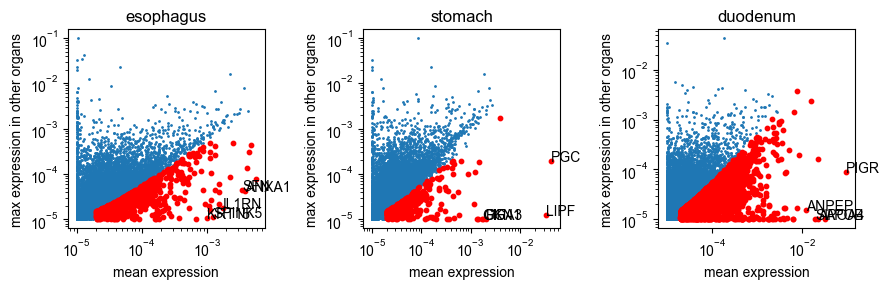

In [18]:
# identify marker genes for each organ
MIN_EXP = 1e-5
MIN_FC = 2
PN=1e-5
N_markers = 5
fig_size_side = 3

markers_dict = dict()

#n_side = int(np.ceil(len(bulk_biopsies_ugi.columns)**0.5))
n_figs = len(bulk_biopsies_ugi.columns)
fig, axs = plt.subplots(1, n_figs, figsize=(fig_size_side*n_figs, fig_size_side))
# make the subplots access in linear order
axs = axs.flatten()
for i, cell_type in enumerate(bulk_biopsies_ugi.columns):
    print(cell_type)
    mean_type = bulk_biopsies_ugi[cell_type]
    max_others = bulk_biopsies_ugi.drop(columns=[cell_type]).max(axis=1)
    # identify genes that have mean expression in the type and at least MIN_FC higher than the max expression in the other types
    selection_mask = (mean_type > MIN_EXP) * (mean_type > MIN_FC * max_others)
    markers = bulk_biopsies_ugi.loc[selection_mask]
    markers_dict[cell_type] = markers.index

    fc_ratio = (PN+mean_type[selection_mask])/(PN+max_others[selection_mask])
    # sort markers by fold change
    markers = markers.loc[fc_ratio.sort_values(ascending=False).index]

    # scatter plot mean expression in the specific cell type vs. max expression in the other types
    ax = axs[i]
    ax.scatter(mean_type+PN, max_others+PN, s=1)
    # color markers in red
    for gene in markers.index:
        ax.scatter(mean_type[gene]+PN, max_others[gene]+PN, s=10, color='red')

    text = []
    for gene in markers.index[:N_markers]:
        text.append(ax.text((mean_type[gene]+PN), (max_others[gene]+PN), gene))

    # adjust_text(text, arrowprops=dict(arrowstyle='->', color='red'))

    ax.set_title(cell_type)
    ax.set_xlabel("mean expression")
    ax.set_ylabel("max expression in other organs")
    ax.set_xscale('log')
    ax.set_yscale('log')

# clear the rest of the subplots
for i in range(len(bulk_biopsies_ugi.columns), len(axs)):
    fig.delaxes(axs[i])
    
plt.tight_layout()

plt.show()

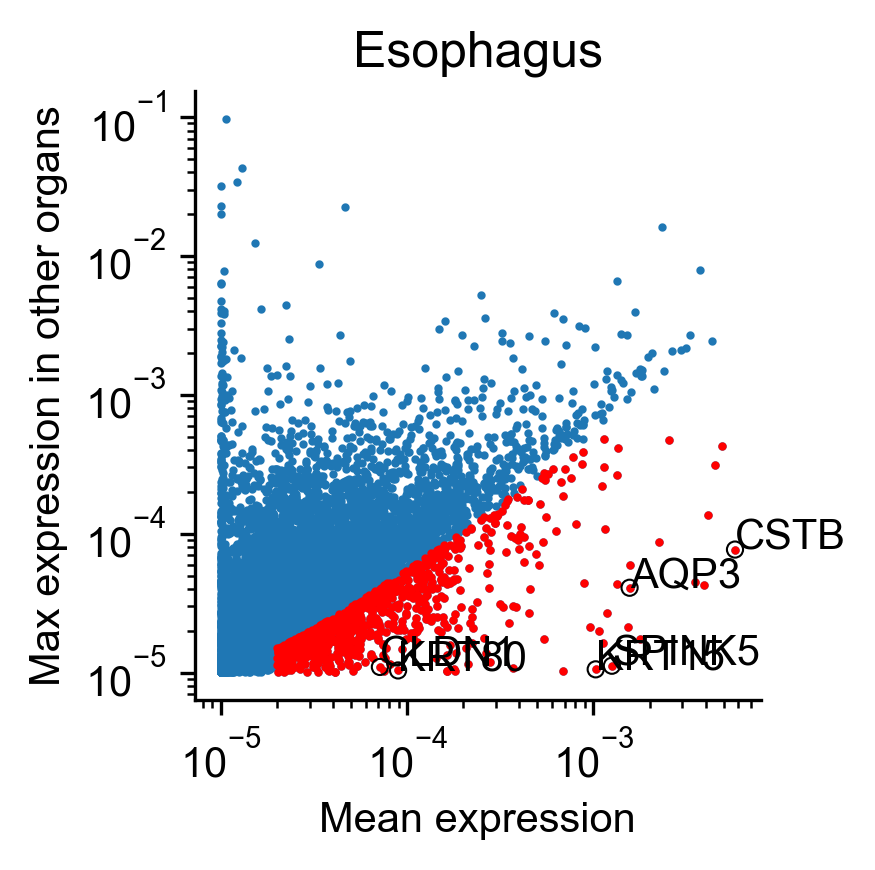

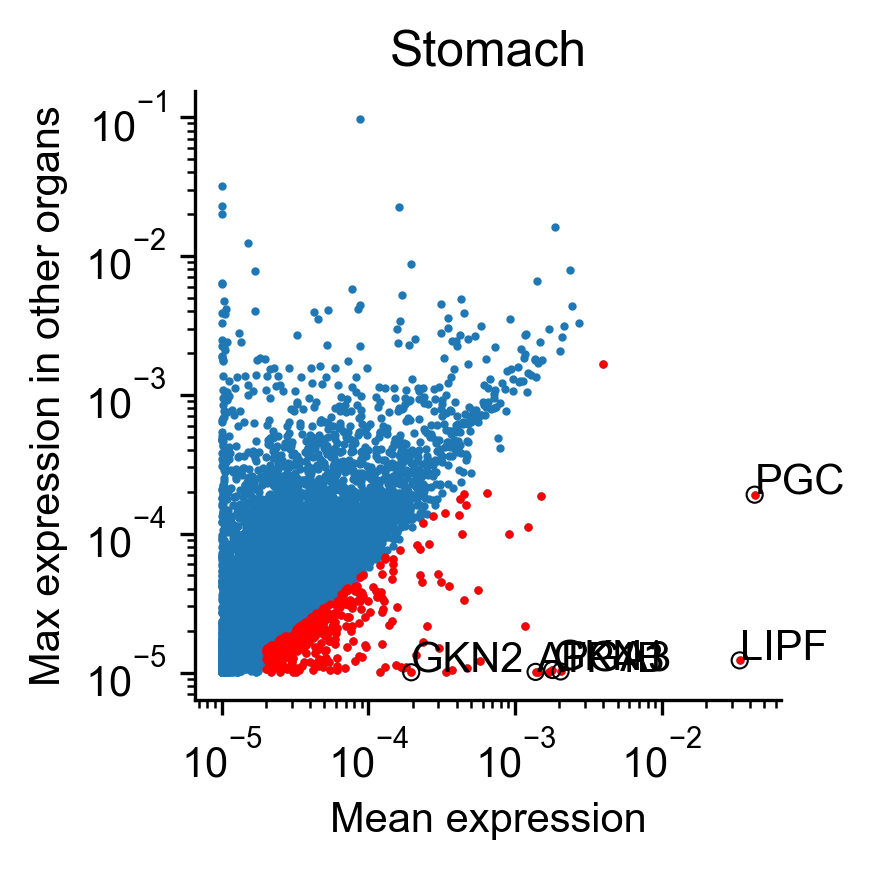

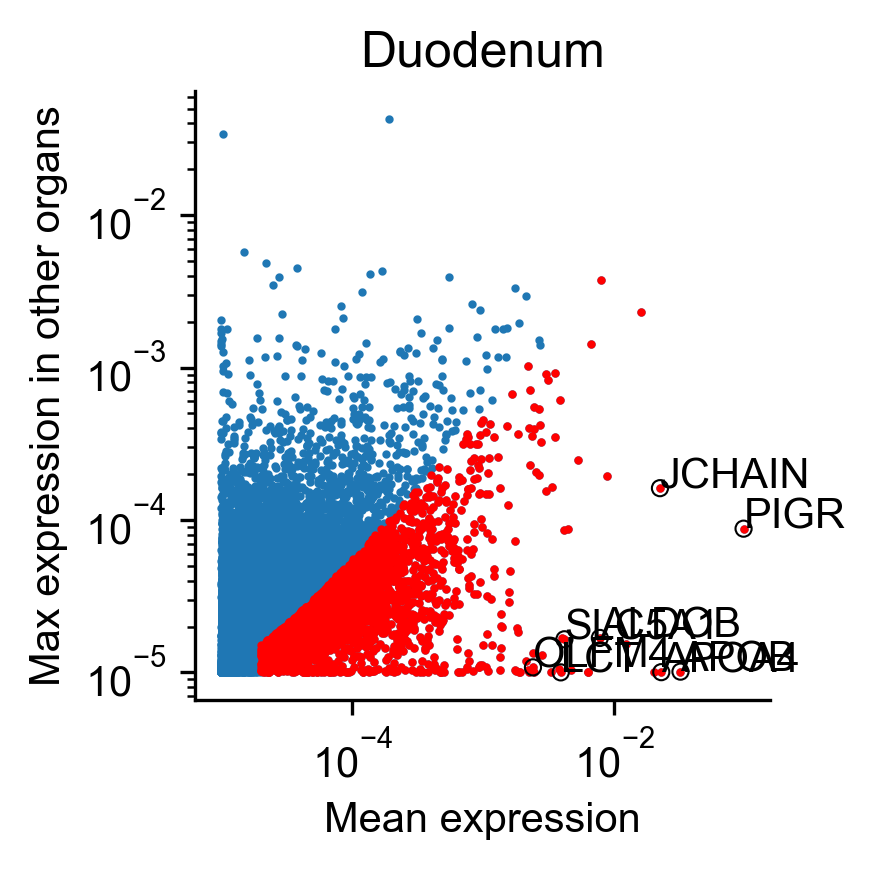

In [19]:
markers_to_show = dict()
markers_to_show['esophagus'] = ["SPINK5","KRT15","AQP3","CSTB","KRT80","CLDN1"]
markers_to_show['stomach'] = ["PGC","LIPF","GKN1","GKN2","ATP4B","PGA3"]
markers_to_show['duodenum'] = ["PIGR","APOB","APOA4","ALDOB","SLC5A1","LCT","JCHAIN","OLFM4"]

my_edge_color = 'black'
USE_ADJUST_TEXT = False
WHITE_LINE_WIDTH = 0
SCATTER_POINT_SIZE = 5

#n_side = int(np.ceil(len(bulk_biopsies_ugi.columns)**0.5))
# n_figs = len(bulk_biopsies_ugi.columns)
# fig, axs = plt.subplots(1, n_figs, figsize=(5*n_figs, 5))
# # make the subplots access in linear order
# axs = axs.flatten()
for i, cell_type in enumerate(bulk_biopsies_ugi.columns):
    fig, axs = plt.subplots(1, 1, figsize=(3, 3), dpi=300)
    # axs = axs.flatten()
    mean_type = bulk_biopsies_ugi[cell_type]
    max_others = bulk_biopsies_ugi.drop(columns=[cell_type]).max(axis=1)
    
    # identify genes that have mean expression in the type and at least MIN_FC higher than the max expression in the other types
    selection_mask = (mean_type > MIN_EXP) * (mean_type > MIN_FC * max_others)
    markers = bulk_biopsies_ugi.loc[selection_mask]
    markers_dict[cell_type] = markers.index

    fc_ratio = (PN+mean_type[selection_mask])/(PN+max_others[selection_mask])
    # sort markers by fold change
    markers = markers.loc[fc_ratio.sort_values(ascending=False).index]

    # scatter plot mean expression in the specific cell type vs. max expression in the other types
    ax = axs
    ax.scatter(mean_type+PN, max_others+PN, s=1)
    # color markers in red
    for gene in markers.index:
        ax.scatter(mean_type[gene]+PN, max_others[gene]+PN, s=1, color='red')

    type_df = pd.DataFrame({'mean':mean_type+PN, 'max':max_others+PN, 'gene':mean_type.index})
    sns.scatterplot(data=type_df.loc[markers_to_show[cell_type]], x="mean", y="max", edgecolor=my_edge_color, linewidth=0.5, s=SCATTER_POINT_SIZE*3, facecolor="none")

    text = []
    for gene in markers_to_show[cell_type]:
        # text.append(ax.text((mean_type[gene]+PN), (max_others[gene]+PN), gene))
        txt = plt.text((mean_type[gene]+PN), (max_others[gene]+PN), gene)
        if WHITE_LINE_WIDTH > 0:
            txt.set_path_effects([PathEffects.withStroke(linewidth=WHITE_LINE_WIDTH, foreground='w')])
        text.append(txt)

    ax.set_title(cell_type.capitalize())
    ax.set_xlabel("Mean expression")
    ax.set_ylabel("Max expression in other organs")
    ax.set_xscale('log')
    ax.set_yscale('log')

    if USE_ADJUST_TEXT:
        adjust_text(text, arrowprops=dict(arrowstyle="-"))
  
    plt.tight_layout()
    ax.spines[['right', 'top']].set_visible(False)

    plt.show()
    fig.savefig(PROJ_MAIN_FOLDER+"edf1_"+cell_type+"_markers.pdf", bbox_inches='tight')

In [20]:
# create an empty dataframe to store the marker genes for each organ
max_marker_len = max(len(markers) for markers in markers_dict.values())
markers_df = pd.DataFrame(index=range(max_marker_len), columns=markers_dict.keys())

for organ, markers in markers_dict.items():
    markers_df.loc[:len(markers) - 1, organ] = markers.values

# markers_df.to_csv(PROJ_MAIN_FOLDER+"TableS4_markers_df.csv")
# Write the markers to the main sheet
markers_df_to_save = markers_df.copy()
markers_df_to_save.index = markers_df_to_save.index + 1
with pd.ExcelWriter(PROJ_MAIN_FOLDER+dataset_ev3_name.replace('.csv', '.xlsx')) as writer:
    markers_df_to_save.to_excel(writer, sheet_name='markers')
    # Add a legend sheet
    legend_text = (
        "Dataset EV3: Marker genes for Esophagus, Stomach and Duodenum, based on bulk RNAseq data."
    )
    legend_df = pd.DataFrame({'Legend': [legend_text]})
    legend_df.to_excel(writer, sheet_name='legend', index=False)

In [21]:
# load bilomics data
# adata = sc.read_h5ad(PROJ_MAIN_FOLDER+r"Raw_anndata_NGT_Controls.h5ad")
adata = sc.read_h5ad(PROJ_MAIN_FOLDER+r"Raw-pc_anndata_preop_umi.h5ad")


In [22]:
legend_ev1 = pd.DataFrame(["Dataset EV1: Raw counts matrix for NGT samples."])
legend_ev2 = pd.DataFrame(["Dataset EV2: Patient metadata for NGT samples."])

In [23]:
# export dataset EV1
with pd.ExcelWriter(PROJ_MAIN_FOLDER+dataset_ev1_name.replace('.csv', '.xlsx'), engine="openpyxl") as writer:
    adata.to_df().T.to_excel(writer, sheet_name="counts", index=True)
    legend_ev1.to_excel(writer, sheet_name="Legend", index=False, header=False)

In [24]:
# export dataset EV2
with pd.ExcelWriter(PROJ_MAIN_FOLDER+dataset_ev2_name.replace('.csv', '.xlsx'), engine="openpyxl") as writer:
    adata.obs[np.setdiff1d(adata.obs.columns, 
                        ['max_organ', 'max_organ_num', 'anatomy preop', 'space','sum_of_umis','log10_sum_of_umis','time','bc seq','fraction']
                        )].to_excel(writer, sheet_name="counts", index=True)
    legend_ev2.to_excel(writer, sheet_name="Legend", index=False, header=False)

In [25]:
# export supplementary tables - OLD VERSION
# adata.to_df().to_csv(PROJ_MAIN_FOLDER+"TableS2_NGT_counts.csv")
# adata.to_df().T.to_excel(PROJ_MAIN_FOLDER+dataset_ev1_name.replace('.csv', '.xlsx'), sheet_name='counts')
# adata.obs[np.setdiff1d(adata.obs.columns, 
#                        ['max_organ', 'max_organ_num', 'anatomy preop', 'space','sum_of_umis','log10_sum_of_umis','time','bc seq','fraction']
#                        )].to_csv(PROJ_MAIN_FOLDER+dataset_ev2_name)



In [26]:
# remove MT genes + Ribosomal + specific genes
print(adata.shape)
specific_genes_to_remove = ["MTRNR2L12", "MTRNR2L1", "MTRNR2L8"]
filter_genes = adata.var_names.str.startswith("MT-") + adata.var_names.isin(specific_genes_to_remove) + adata.var_names.str.contains("RPL") + adata.var_names.str.contains("RPS")
adata = adata[:,~filter_genes]
# select only protein coding genes
print(adata.shape)
biomart_tbl = pd.read_csv(utils_path+'/Human_GRch38_91_ensemblBioMart_ref.csv')
biomart_tbl = biomart_tbl.loc[(biomart_tbl['gene_biotype'] == "protein_coding")] 
adata = adata[:,np.intersect1d(adata.var_names, biomart_tbl.external_gene_name)]
print(adata.shape)
adata.X = adata.layers['seq_data'].copy()
# calc sum of umis
adata.obs.drop(['sum_of_umis', 'log10_sum_of_umis'], axis=1, errors='ignore', inplace=True)
adata.obs['sum_of_umis'] = adata.layers['seq_data'].sum(axis=1).astype(int)
adata.obs['log10_sum_of_umis'] = np.log10(adata.obs['sum_of_umis'])

adata.layers['mat_norm'] = adata.X / adata.X.sum(axis=1)[:, np.newaxis]

UMI_THRESH = 10000
print("Starting "+str(adata.shape))
adata = adata[adata.obs['cancer'] == "Control"]
print("Controls "+str(adata.shape))
adata = adata[adata.obs['drain'] == "NGT"]
print("NGTs "+str(adata.shape))
adata = adata[adata.obs['sum_of_umis'] > UMI_THRESH]
print("Sum of UMIS > "+str(UMI_THRESH)+" "+str(adata.shape))
# remove patient that undergone whipple surgery
if len(np.where([x for x in adata.obs['psh'].astype(str).str.contains("Whipple")])[0]) > 0:
    adata = adata[np.setdiff1d(adata.obs_names,adata.obs_names[np.where([x for x in adata.obs['psh'].astype(str).str.contains("Whipple")])[0]][0])]
print("Without patients with history of whipple surgery "+str(adata.shape))

adata

(31, 19096)
(31, 19096)
(31, 19096)
Starting (31, 19096)
Controls (31, 19096)
NGTs (31, 19096)
Sum of UMIS > 10000 (31, 19096)
Without patients with history of whipple surgery (31, 19096)


/tmp/ipykernel_982853/4212871953.py:12: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata.X = adata.layers['seq_data'].copy()


View of AnnData object with n_obs × n_vars = 31 × 19096
    obs: 'sample_name', 'notes', 'drain', 'cancer', 'time', 'batch', 'id', 'age', 'sex', 'bmi', 'diagnosis', 'surgery type', 'cea', 'ca-19-9', 'afp', 'meds', 'antacids', 'pmh', 'psh', 'chemo', 'cancer_crc', 'sum_of_umis', 'log10_sum_of_umis'
    var: 'gene_name'
    uns: 'raw_created'
    layers: 'mat_norm', 'seq_data'

In [27]:
# create table 1 - This table is now within the text of the paper
tbl1_df = pd.DataFrame(columns=[''])
tbl1_df.loc['Number of samples'] = adata.shape[0]
tbl1_df.loc['Age (mean+-std)'] = f"{adata.obs.age.astype(float).mean():.2f}+-{adata.obs.age.astype(float).std():.2f}"
tbl1_df.loc["Females (%)"] = f"{(adata.obs.sex=='Female').sum()} ({100*(adata.obs.sex=='Female').mean():.1f})"
tbl1_df.loc['Body mass index (mean+-std)'] = f"{adata.obs.bmi.astype(float).mean():.1f}+-{adata.obs.bmi.astype(float).std():.1f}"
# tbl1_df.to_csv(PROJ_MAIN_FOLDER+"TableS1_ngt_patients.csv")

In [28]:
mean_vec = adata.layers['mat_norm'].mean(axis=0)
# duplocate the mean vector to create a matrix for the dataframe
shed_means_df = pd.DataFrame(mean_vec, index=adata.var_names, columns=['mean'])
shed_means_df['mean2'] = shed_means_df['mean']
shed_means_df['mean3'] = shed_means_df['mean']
shed_means_df = shed_means_df.dropna()
shed_means_df.columns = ['esophagus', 'stomach', 'duodenum']
shed_means_df = shed_means_df.T
shed_means_df

gene_name,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
esophagus,0.000002,0.000006,0.000007,0.000578,0.0,0.000012,9.341810e-09,0.000002,0.000021,0.000039,...,0.000006,0.000004,0.000002,4.381169e-07,0.000003,0.000009,4.880456e-07,0.00001,0.000049,0.000089
stomach,0.000002,0.000006,0.000007,0.000578,0.0,0.000012,9.341810e-09,0.000002,0.000021,0.000039,...,0.000006,0.000004,0.000002,4.381169e-07,0.000003,0.000009,4.880456e-07,0.00001,0.000049,0.000089
duodenum,0.000002,0.000006,0.000007,0.000578,0.0,0.000012,9.341810e-09,0.000002,0.000021,0.000039,...,0.000006,0.000004,0.000002,4.381169e-07,0.000003,0.000009,4.880456e-07,0.00001,0.000049,0.000089


In [29]:
# dataframe to anndata
adata_mix_wash_obs = pd.DataFrame(shed_means_df.index, columns=['organ'], index=shed_means_df.index+"_wash")
adata_mix_wash_obs['sample_type'] = 'wash' 

adata_mix_wash = sc.AnnData(X=shed_means_df.values, obs=adata_mix_wash_obs, var=pd.DataFrame(shed_means_df.columns, columns=['gene_name'], index=shed_means_df.columns))
adata_mix_wash

AnnData object with n_obs × n_vars = 3 × 19096
    obs: 'organ', 'sample_type'
    var: 'gene_name'

In [30]:
bulk_biopsies_ugi = bulk_biopsies_ugi.T

In [31]:
adata_mix_biopsies_obs = pd.DataFrame(bulk_biopsies_ugi.index, columns=['organ'], index=bulk_biopsies_ugi.index+"_biopsy")
adata_mix_biopsies_obs['sample_type'] = 'biopsy'

adata_mix_biopsies = sc.AnnData(X=bulk_biopsies_ugi.values, obs=adata_mix_biopsies_obs, var=pd.DataFrame(bulk_biopsies_ugi.columns, columns=['gene_name'], index=bulk_biopsies_ugi.columns))
adata_mix_biopsies

AnnData object with n_obs × n_vars = 3 × 13743
    obs: 'organ', 'sample_type'
    var: 'gene_name'

In [32]:
# merge two anndatas
adata_mix = sc.concat([adata_mix_wash, adata_mix_biopsies])#adata_mix.concatenate(adata_mix_biopsies)
print(adata_mix.shape)
adata_mix

(6, 13151)


AnnData object with n_obs × n_vars = 6 × 13151
    obs: 'organ', 'sample_type'

In [33]:
# normalize the data
adata_mix.layers['mat_norm'] = adata_mix.X / adata_mix.X.sum(axis=1)[:, np.newaxis]

esophagus
using 807 marker genes
Correlation: 0.5844965061105926, p-value: 4.1081437500544345e-75


/mnt/x/common/Lab_Papers/shedding_potential/zenodo/utils/shed_funcs.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = model.params[0] + model.params[1] * x  # params[0] is the intercept, params[1] is the slope


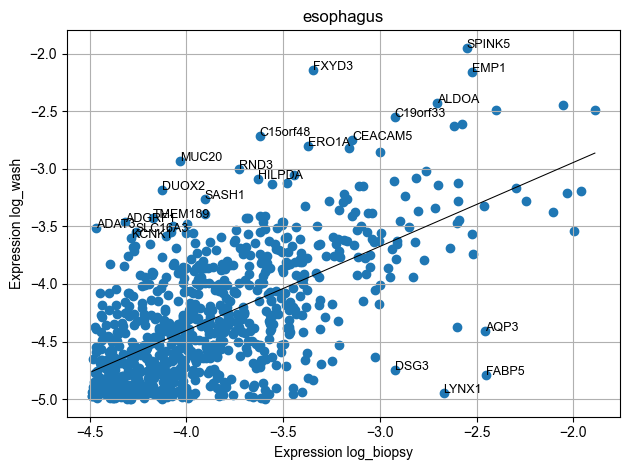

stomach
using 418 marker genes
Correlation: 0.4691509054894646, p-value: 2.8907493149145694e-24


/mnt/x/common/Lab_Papers/shedding_potential/zenodo/utils/shed_funcs.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = model.params[0] + model.params[1] * x  # params[0] is the intercept, params[1] is the slope


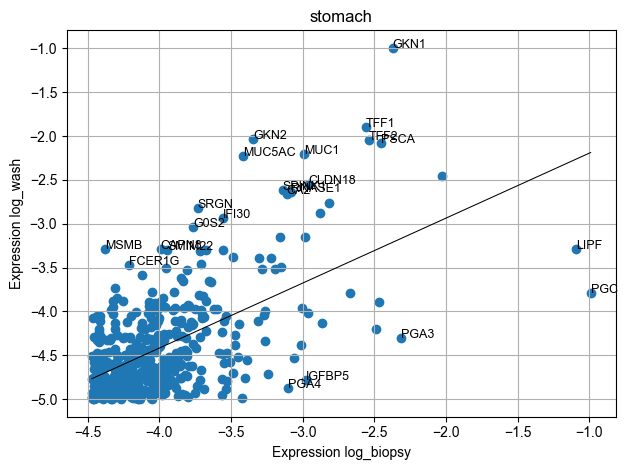

duodenum
using 2426 marker genes
Correlation: 0.6342289356032393, p-value: 3.5651230837476018e-273


/mnt/x/common/Lab_Papers/shedding_potential/zenodo/utils/shed_funcs.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = model.params[0] + model.params[1] * x  # params[0] is the intercept, params[1] is the slope


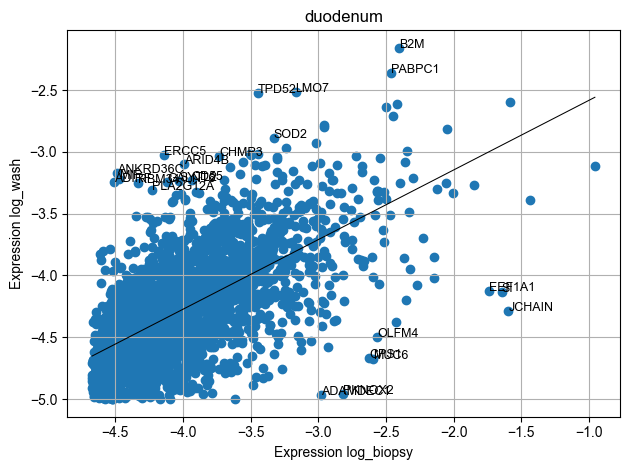

In [34]:
resids_dict = dict()
for organ in adata_mix.obs['organ'].unique():
    print(organ)
    intersected_markers = np.intersect1d(list(markers_dict[organ]), adata_mix.var_names)
    print("using {} marker genes".format(len(intersected_markers)))
    resids_dict[organ] = shed_funcs.calc_resids_by_field(adata_mix[adata_mix.obs['organ'] == organ, intersected_markers], "sample_type", "biopsy", "wash", RESID_THRESH=1, title=organ)
    resids_dict[organ].to_csv(PROJ_MAIN_FOLDER+"residuals_"+organ+".csv")

### create tissue-shed plots with specific genes

In [35]:
import plotly.express as px
tmp_organ = 'duodenum'
# px.scatter(resids_dict[tmp_organ], x='log_biopsy', y='log_wash', color='residual', hover_name=resids_dict[tmp_organ].index)

/mnt/x/common/Lab_Papers/shedding_potential/zenodo/utils/shed_funcs.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = model.params[0] + model.params[1] * x  # params[0] is the intercept, params[1] is the slope


Correlation: 0.5844965061105926, p-value: 4.108144e-75


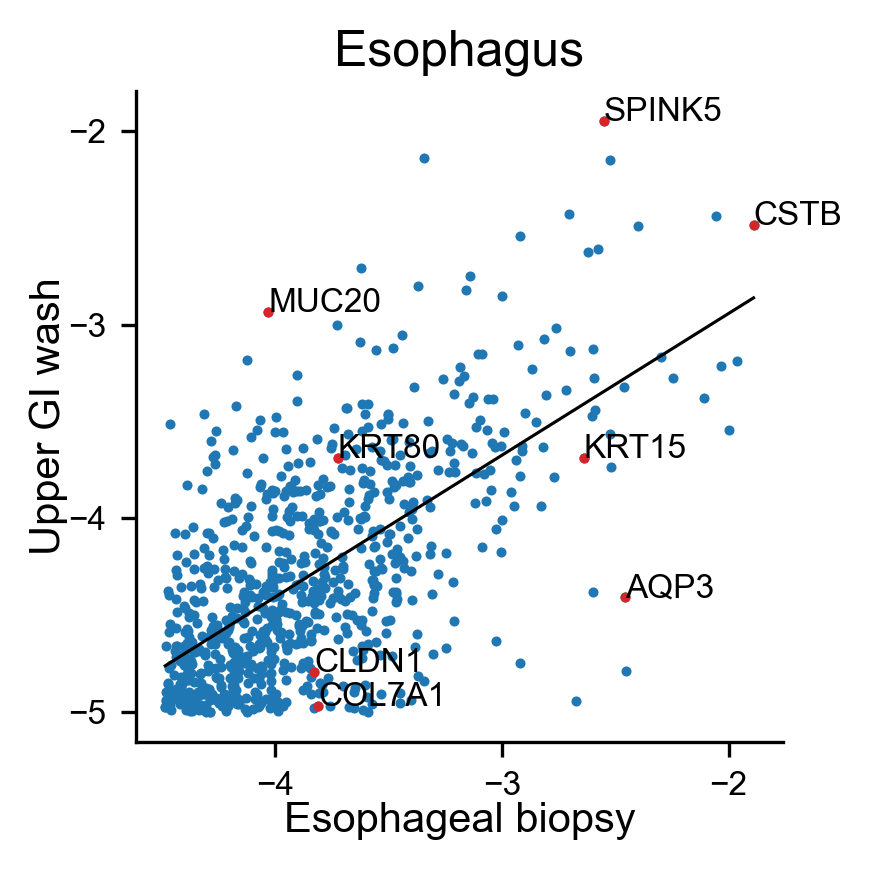

exporting


/mnt/x/common/Lab_Papers/shedding_potential/zenodo/utils/shed_funcs.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = model.params[0] + model.params[1] * x  # params[0] is the intercept, params[1] is the slope


Correlation: 0.4691509054894646, p-value: 2.890749e-24


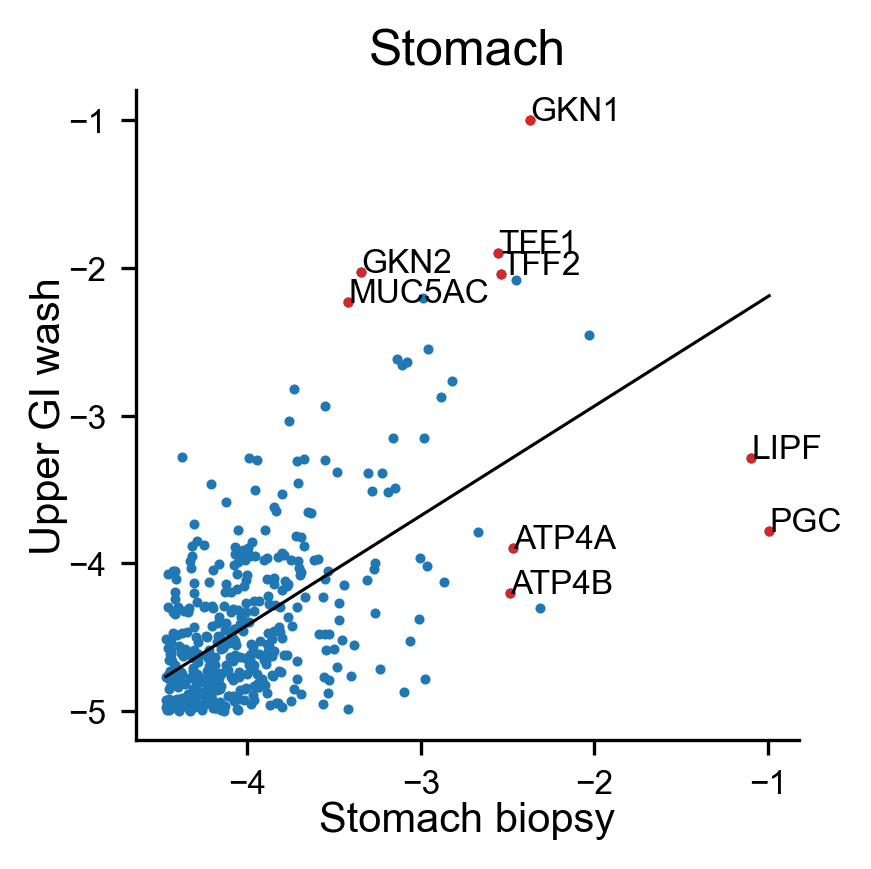

exporting


/mnt/x/common/Lab_Papers/shedding_potential/zenodo/utils/shed_funcs.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = model.params[0] + model.params[1] * x  # params[0] is the intercept, params[1] is the slope


Correlation: 0.6342289356032393, p-value: 3.565123e-273


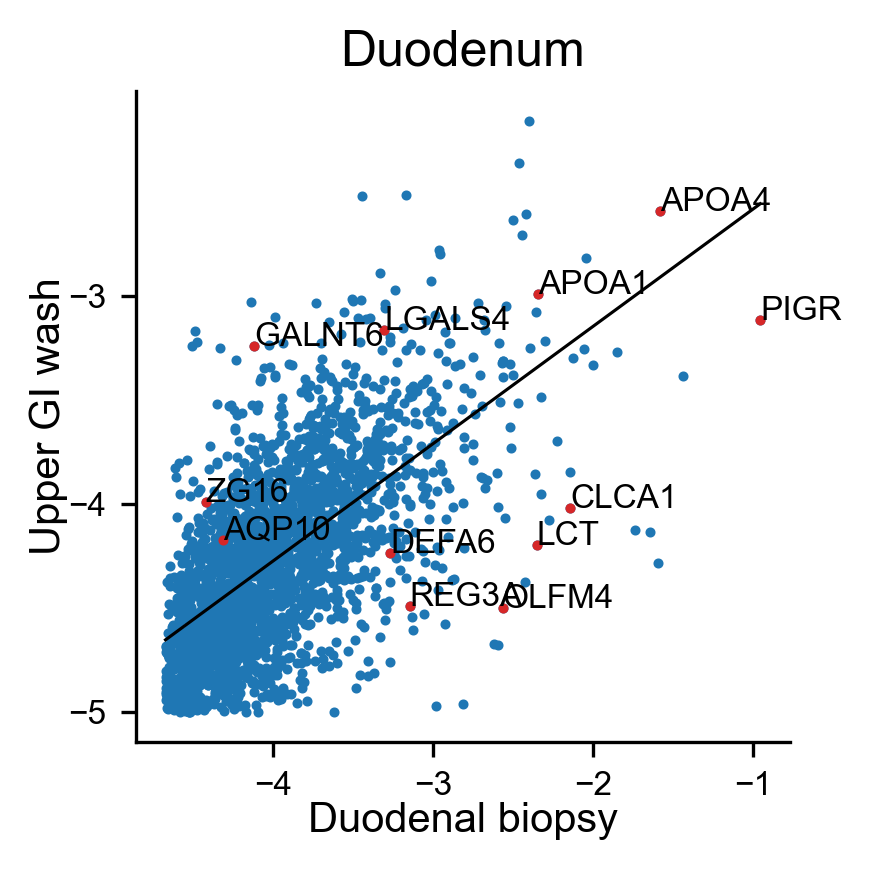

exporting


In [36]:
shed_funcs.plot_tissue_shed_for_fig(resids_dict['esophagus'], ['SPINK5','TUBB','CSTB','MUC4','MYL9','STMN1','KRT15','AQP3',"KRT80","CLDN1","MUC20","COL7A1"], fontsize=8,figsize=(3,3),spot_size=2, add_arrows=False, reg_line_width=0.75,
                                    exp_path=PROJ_MAIN_FOLDER+"Fig3b_esophagus.pdf",white_outline_width=0, title="Esophagus", my_xlabel="Esophageal biopsy", my_ylabel="Upper GI wash", use_adjust_text=False)
shed_funcs.plot_tissue_shed_for_fig(resids_dict['stomach'], ['GKN1','SLC5A5','PGC','LIPF','ATP4A','ATP4B','TFF1','TFF2','GKN2','MUC5AC','MUC6'], fontsize=8,figsize=(3,3),spot_size=2, add_arrows=False, reg_line_width=0.75,
                                    exp_path=PROJ_MAIN_FOLDER+"Fig3c_stomach.pdf",white_outline_width=0, title="Stomach", my_xlabel="Stomach biopsy", my_ylabel="Upper GI wash", use_adjust_text=False)
shed_funcs.plot_tissue_shed_for_fig(resids_dict['duodenum'], ['OLFM4','CLCA1',"LGALS4",'DEFA6','ZG16','REG3A',"PIGR","LCT",'AQP10','APOA4','APOA1',"GALNT6"], fontsize=8,figsize=(3,3),spot_size=2, add_arrows=False, reg_line_width=0.75,
                                    exp_path=PROJ_MAIN_FOLDER+"Fig3d_duodenum.pdf",white_outline_width=0, title="Duodenum", my_xlabel="Duodenal biopsy", my_ylabel="Upper GI wash", use_adjust_text=False)

In [37]:
# export duodenum residuals for yotam's analysis
resids_dict['duodenum'].to_csv(PROJ_MAIN_FOLDER+'/duodenum_residuals.csv')

## Use biopsies data to identify marker genes for each organ

In [38]:
EXP_THRESH = 1e-5
FC_THRESH = 2
PN=1e-6
markers_dict = dict()
for organ in bulk_biopsies_ugi.index:
    mean_type = bulk_biopsies_ugi.loc[organ]
    max_others = bulk_biopsies_ugi.drop(index=[organ]).max(axis=0)
    # identify genes that have mean expression in the type and at least MIN_FC higher than the max expression in the other types
    selection_mask = (mean_type > EXP_THRESH) * (mean_type > FC_THRESH * max_others)
    markers = bulk_biopsies_ugi.columns[selection_mask]
    markers_dict[organ] = markers
    print(organ+" # markers: "+str(len(markers)))

esophagus # markers: 834
stomach # markers: 427
duodenum # markers: 2504


## Load busslinger's data

In [39]:
if EXPORT_ORGANS:
    organs_adatas = dict()
    organs_adatas['esophagus'] = sc.read_h5ad(PROJ_MAIN_FOLDER+"busslinger_ugi/adata_esophagus.h5ad")
    organs_adatas['stomach'] = sc.read_h5ad(PROJ_MAIN_FOLDER+"busslinger_ugi/adata_stomach.h5ad")
    organs_adatas['duodenum'] = sc.read_h5ad(PROJ_MAIN_FOLDER+"busslinger_ugi/adata_duodenum.h5ad")
    organs_adatas_orig = organs_adatas.copy()
    organs_adatas

In [40]:
# keep only HVGs within each organ
for organ, adata in organs_adatas.items():
    print(organ)
    # sc.pl.highly_variable_genes(organs_adatas[organ])
    print(adata.shape)
    adata = adata[:,adata.var['highly_variable']]
    print(adata.shape)
    organs_adatas[organ] = adata
    # sc.pl.highly_variable_genes(organs_adatas[organ])


esophagus
(411, 17138)
(411, 2130)
stomach
(1072, 17138)
(1072, 2019)
duodenum
(284, 17138)
(284, 2057)


In [41]:
for organ in organs_adatas.keys():
    print(organ)
    bdata_organ = organs_adatas[organ].copy()
    print(bdata_organ.shape)

    my_resids = resids_dict[organ]
    my_resids = my_resids.loc[np.intersect1d(my_resids.index, bdata_organ.var_names)]

    intersect_genes = np.intersect1d(my_resids.index, bdata_organ.var_names)
    organ_shedding_resids = my_resids.loc[intersect_genes]

    bdata_organ.obs['shedding_score'] = None
    bdata_organ.var['shedding_residual'] = None
    bdata_organ.var.loc[organ_shedding_resids.index, 'shedding_residual']= organ_shedding_resids['residual']
    
    bdata_organ = bdata_organ[:, my_resids.index]

    bdata_organ.X = bdata_organ.layers['mat_norm']
    sc.pp.normalize_total(bdata_organ, target_sum=1, exclude_highly_expressed=True, max_fraction=0.1)
    
    resids_vals = np.array(bdata_organ.var['shedding_residual'])
    resids_vals = np.expand_dims(resids_vals, axis=1)
    resids_matnorm = bdata_organ.layers['mat_norm']

    shedding_scores = resids_matnorm @ resids_vals # This line is critical

    bdata_organ.obs['shedding_score'] = [float(x) for x in shedding_scores]

    organs_adatas[organ] = bdata_organ

esophagus
(411, 2130)
stomach


/tmp/ipykernel_982853/2808565806.py:18: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  bdata_organ.X = bdata_organ.layers['mat_norm']
/home/talbarka/miniconda3/envs/turnover_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/tmp/ipykernel_982853/2808565806.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bdata_organ.obs['shedding_score'] = [float(x) for x in shedding_scores]
/tmp/ipykernel_982853/2808565806.py:18: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  bdata_organ.X = bdata_organ.layers['mat_norm']
/home/talbarka/miniconda3/envs/turnover_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:269

(1072, 2019)
duodenum
(284, 2057)


/tmp/ipykernel_982853/2808565806.py:18: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  bdata_organ.X = bdata_organ.layers['mat_norm']
/home/talbarka/miniconda3/envs/turnover_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/tmp/ipykernel_982853/2808565806.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bdata_organ.obs['shedding_score'] = [float(x) for x in shedding_scores]


/tmp/ipykernel_982853/688512202.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_types_median = organs_adatas[my_organ].obs.groupby(use_field)['shedding_score'].median()
/tmp/ipykernel_982853/688512202.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cell_types_ord, rotation=45, ha='right')


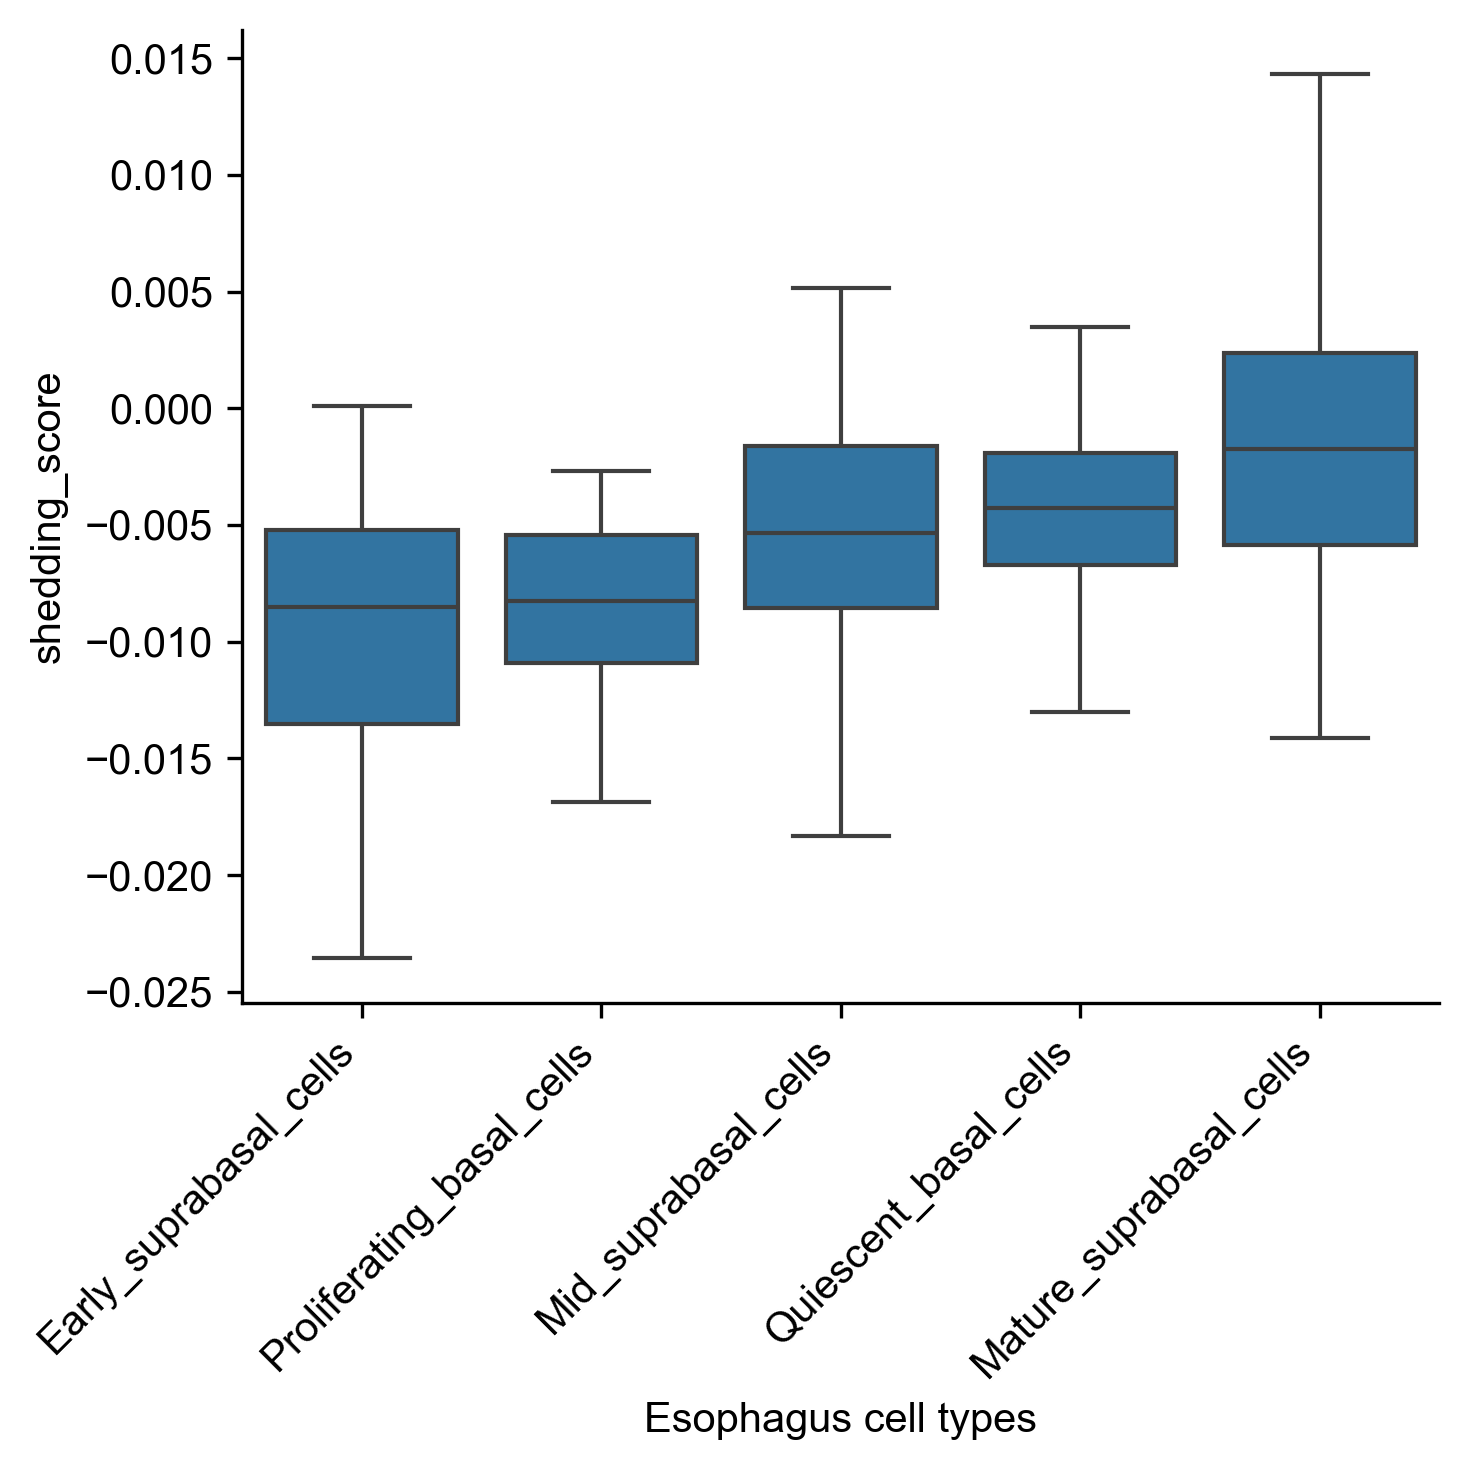

/tmp/ipykernel_982853/688512202.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_types_median = organs_adatas[my_organ].obs.groupby(use_field)['shedding_score'].median()
/tmp/ipykernel_982853/688512202.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cell_types_ord, rotation=45, ha='right')


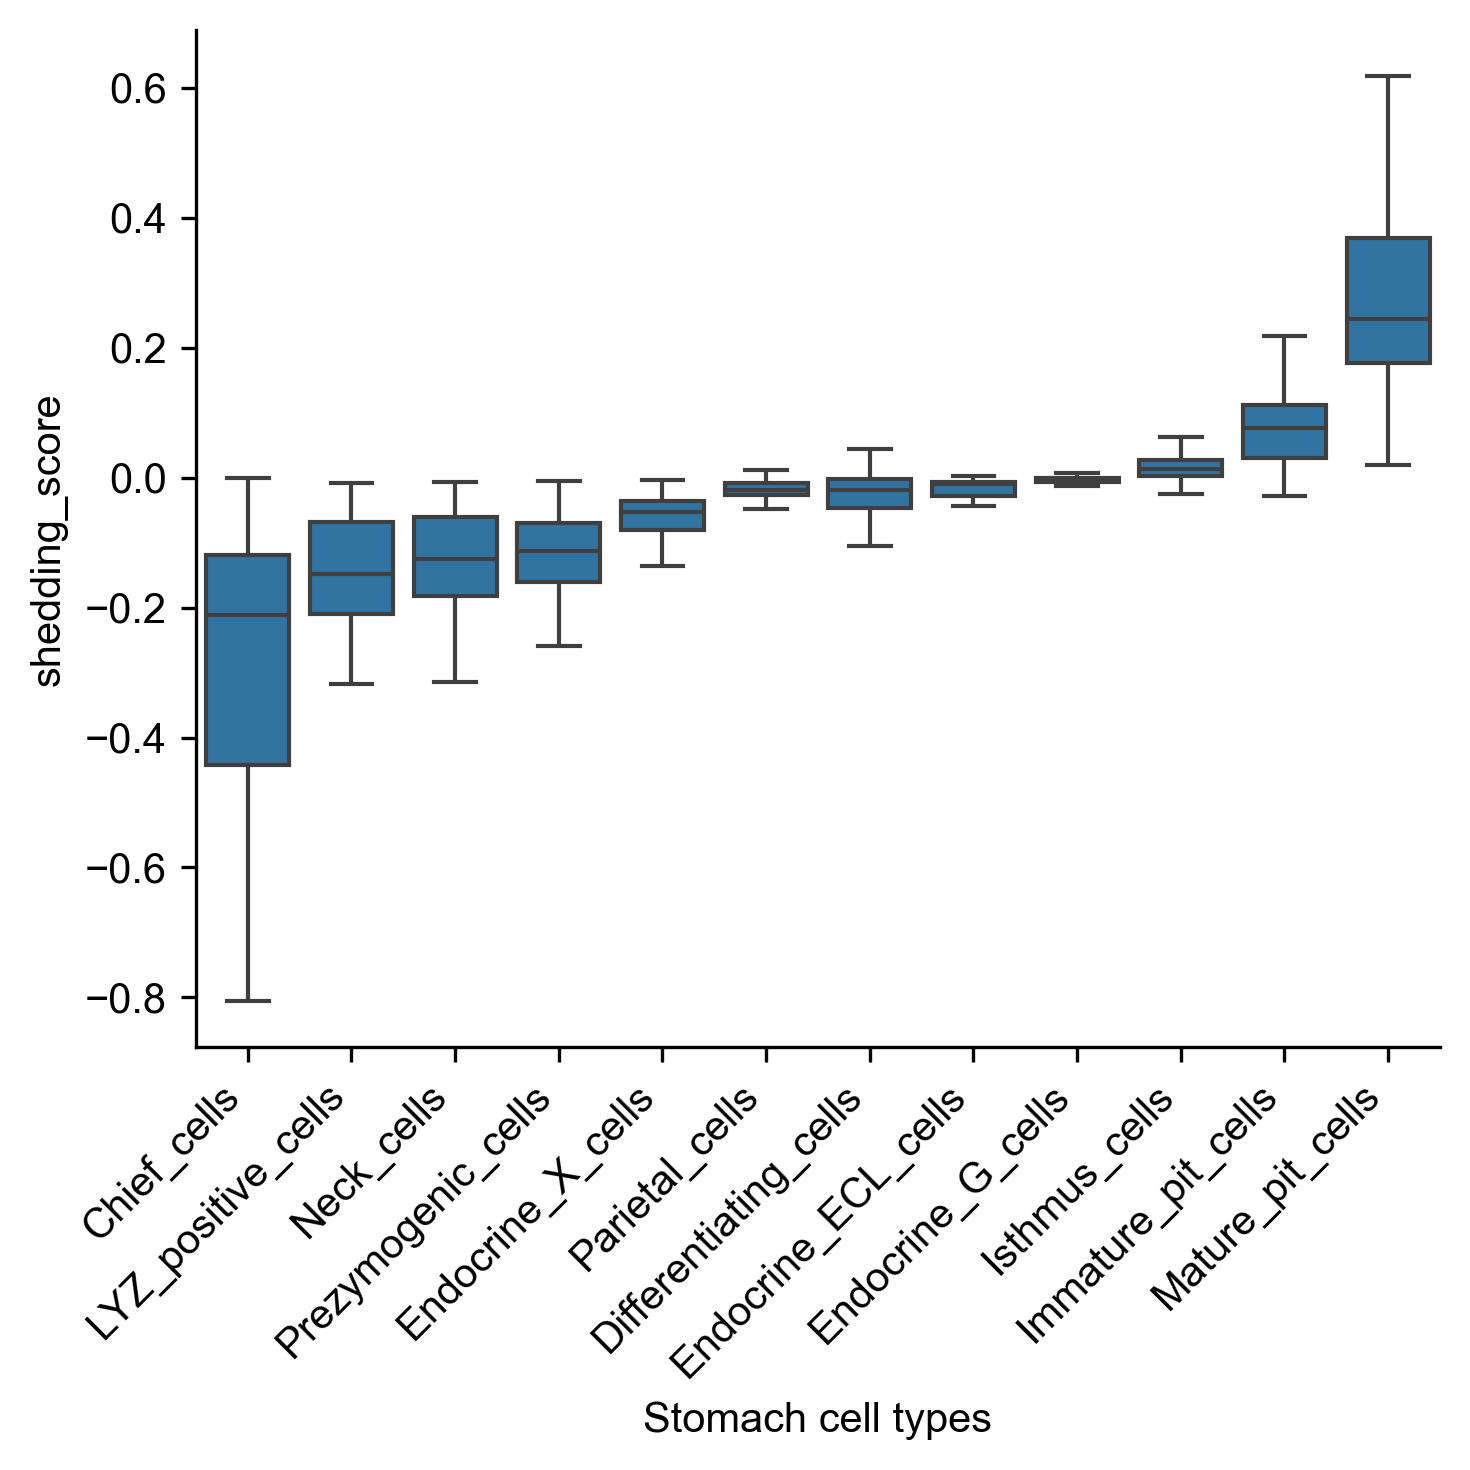

/tmp/ipykernel_982853/688512202.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_types_median = organs_adatas[my_organ].obs.groupby(use_field)['shedding_score'].median()
/tmp/ipykernel_982853/688512202.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cell_types_ord, rotation=45, ha='right')


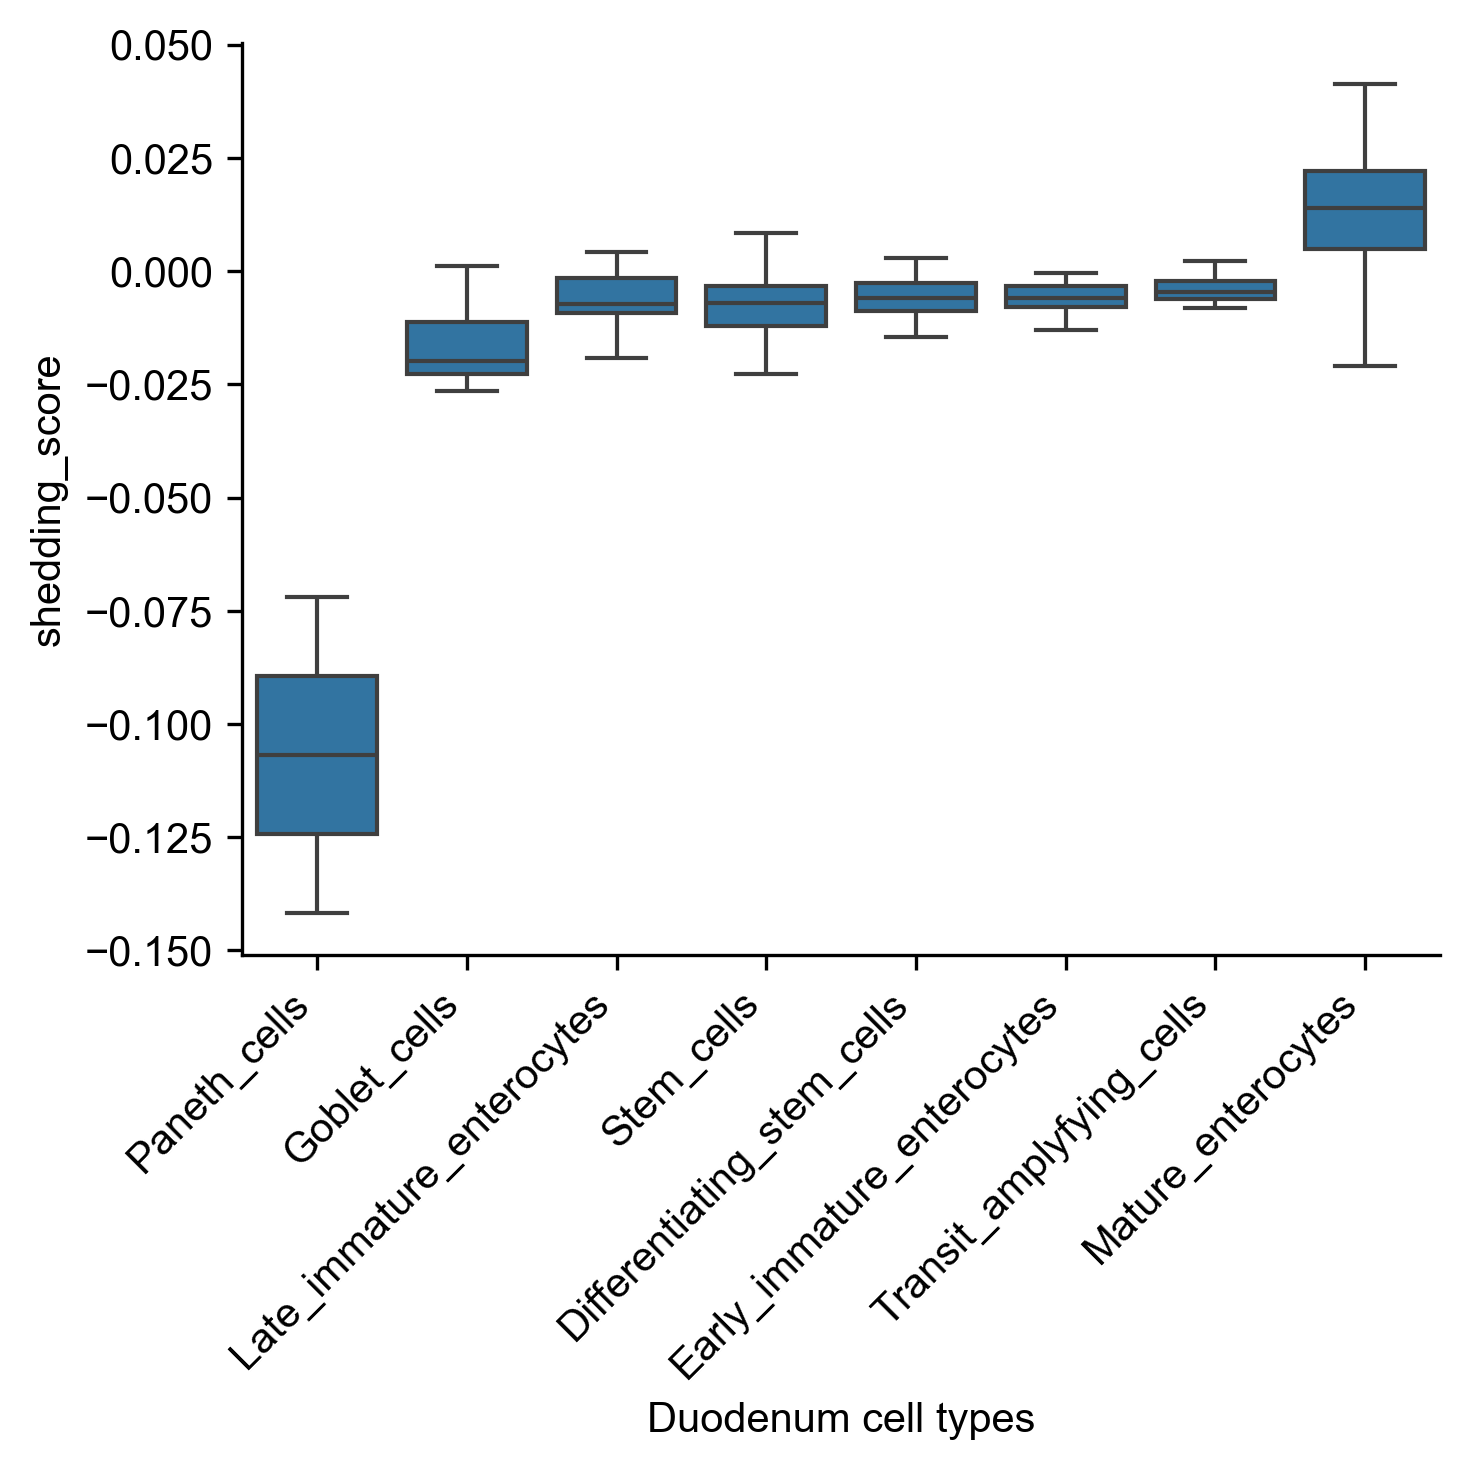

In [42]:
# Calculate the number of rows and columns needed for a square layout
# this is for the supplementary figure
use_field = "cell_type"
for my_organ in organs_adatas.keys():
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
    cell_types = organs_adatas[my_organ].obs[use_field].unique()
    cell_types_median = organs_adatas[my_organ].obs.groupby(use_field)['shedding_score'].median()
    cell_types_ord = cell_types_median.sort_values().index.tolist()

    sns.boxplot(data=organs_adatas[my_organ].obs, x=use_field, y='shedding_score', order=cell_types_ord, ax=ax, showfliers=False)
    # ax.axhline(0, color='black', linestyle='--', zorder=0)
    # ax.set_title(my_organ.capitalize())
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xticklabels(cell_types_ord, rotation=45, ha='right')
    ax.set_xlabel(my_organ.capitalize() + " cell types")
    
    plt.tight_layout()
    plt.show()

In [43]:
organs_adatas['stomach'].obs

,patient_code,organ,compartment,organ_tissue,organ_tissue_duo,cell_type,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,...,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,log10_total_counts,gross_cell_type,leiden,shedding_score
AA004,AA,stomach,Cardia,stomach_cardia,stomach_cardia,Endocrine_X_cells,3667,8.207402,9810.0,9.191259,...,29.153925,37.054027,51.416922,417.0,6.035481,4.250764,3.991669,Endocrine_cells,12,-0.062651
AA007,AA,stomach,Cardia,stomach_cardia,stomach_cardia,Differentiating_cells,2847,7.954372,9116.0,9.117896,...,42.770952,51.261518,64.491005,2010.0,7.606388,22.049145,3.959805,Differentiating_cells,9,0.024574
AA009,AA,stomach,Cardia,stomach_cardia,stomach_cardia,Endocrine_ECL_cells,2126,7.662468,4911.0,8.499436,...,38.627571,46.976176,61.901853,470.0,6.154858,9.570352,3.691170,Endocrine_cells,16,-0.005412
AA011,AA,stomach,Cardia,stomach_cardia,stomach_cardia,Differentiating_cells,2487,7.819234,5734.0,8.654343,...,30.781304,40.373212,57.115452,667.0,6.504288,11.632368,3.758458,Differentiating_cells,9,0.007011
AA012,AA,stomach,Cardia,stomach_cardia,stomach_cardia,Chief_cells,1465,7.290293,2971.0,7.996990,...,44.698755,52.271962,67.519354,203.0,5.318120,6.832716,3.472903,Chief_cells,0,-0.026408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AW372,AW,stomach,Pylorus,stomach_pylorus,stomach_pylorus,Endocrine_ECL_cells,1090,6.994850,1805.0,7.498870,...,34.570637,45.650970,67.313019,277.0,5.627621,15.346260,3.256477,Endocrine_cells,15,-0.008740
AW375,AW,stomach,Pylorus,stomach_pylorus,stomach_pylorus,Isthmus_cells,997,6.905753,2074.0,7.637716,...,49.855352,59.498554,76.036644,700.0,6.552508,33.751205,3.316809,Isthmus_cells,4,-0.000447
AW377,AW,stomach,Pylorus,stomach_pylorus,stomach_pylorus,Neck_cells,1661,7.415777,4378.0,8.384576,...,53.037917,60.529922,73.481042,676.0,6.517671,15.440841,3.641276,Neck_cells,1,-0.190106
AW379,AW,stomach,Pylorus,stomach_pylorus,stomach_pylorus,Endocrine_G_cells,3308,8.104401,9275.0,9.135185,...,38.059299,45.045822,57.595687,852.0,6.748760,9.185984,3.967314,Endocrine_cells,15,0.007431


e esophagus


/tmp/ipykernel_982853/3176629368.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_types_median = obs_to_fig.groupby(use_field)['shedding_score'].median()
/tmp/ipykernel_982853/3176629368.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=obs_to_fig, x=use_field, y='shedding_score', order=cell_types_ord, ax=ax, showfliers=False, palette="tab10")
/tmp/ipykernel_982853/3176629368.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.replace('_', ' ') for label in xticks_labels], rotation=45, ha='right')


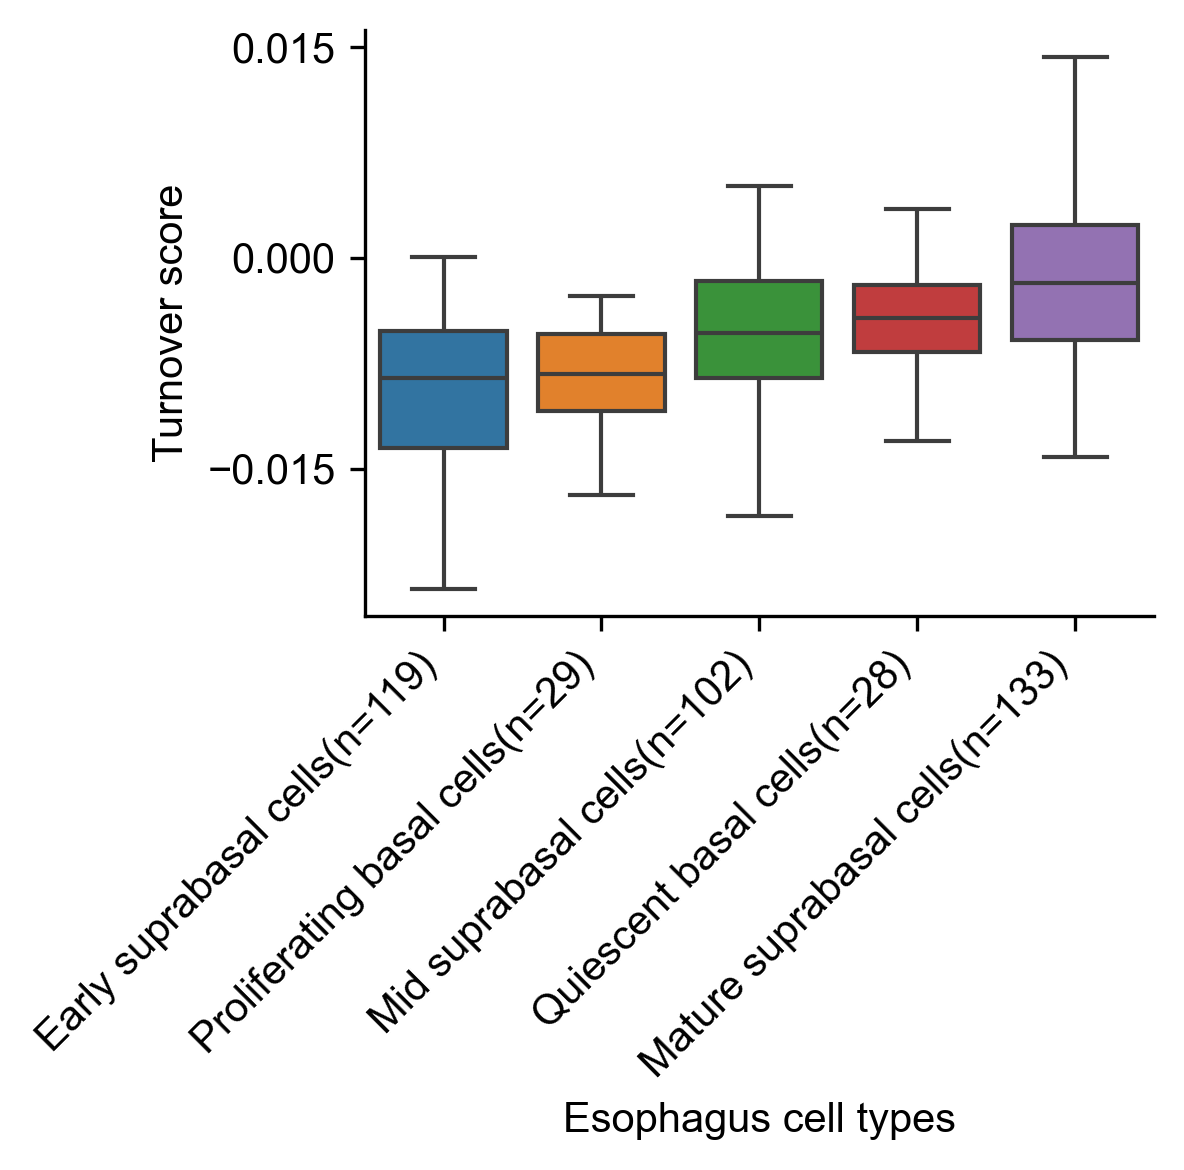

f stomach


/tmp/ipykernel_982853/3176629368.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_types_median = obs_to_fig.groupby(use_field)['shedding_score'].median()
/tmp/ipykernel_982853/3176629368.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=obs_to_fig, x=use_field, y='shedding_score', order=cell_types_ord, ax=ax, showfliers=False, palette="tab10")
/tmp/ipykernel_982853/3176629368.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.replace('_', ' ') for label in xticks_labels], rotation=45, ha='right')


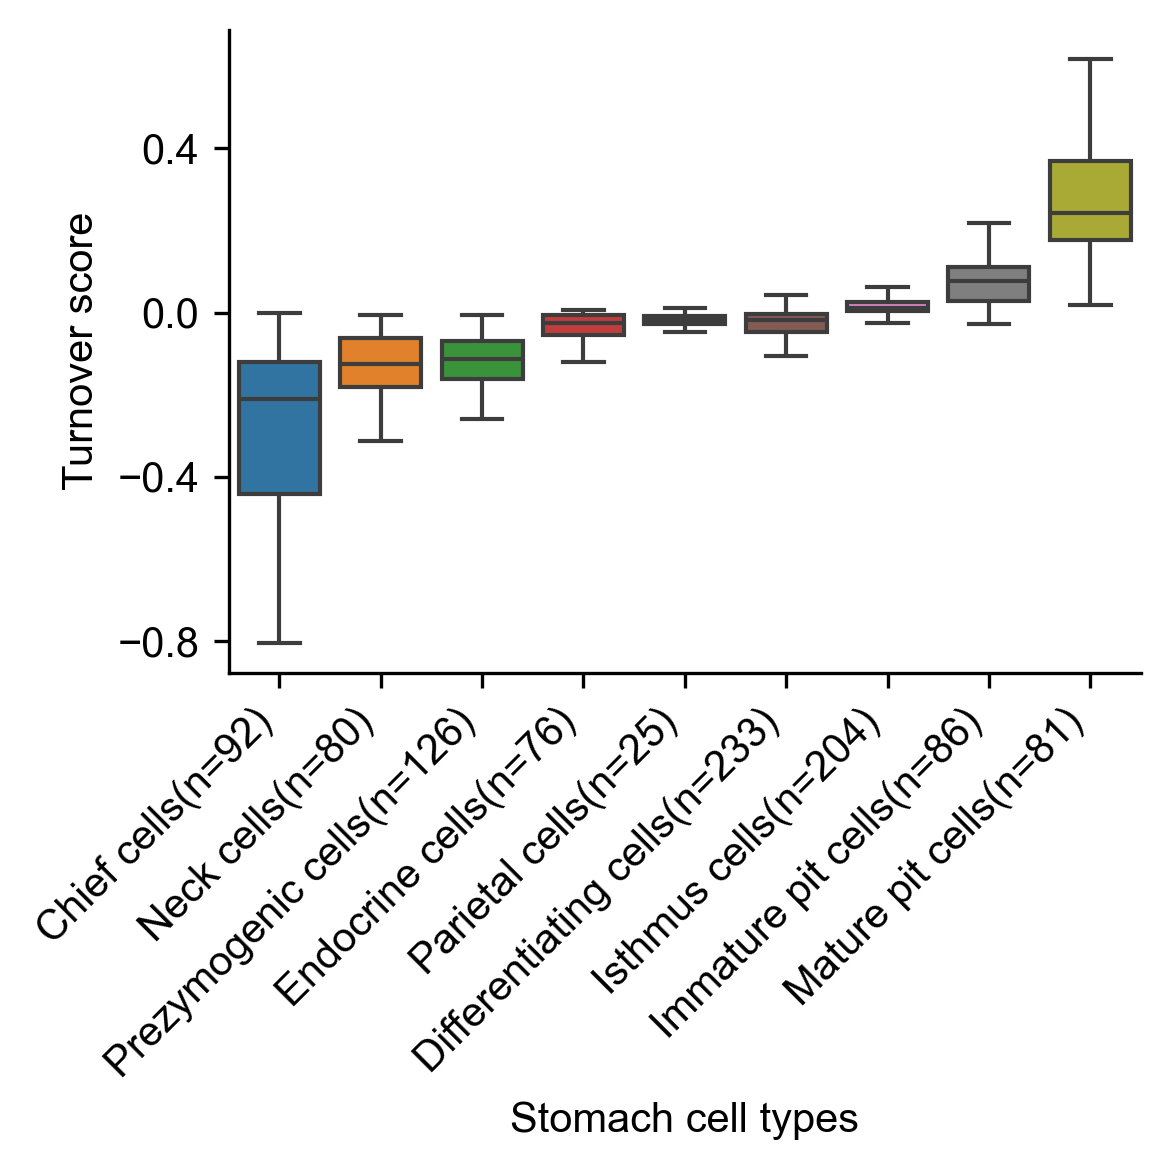

g duodenum


/tmp/ipykernel_982853/3176629368.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_types_median = obs_to_fig.groupby(use_field)['shedding_score'].median()
/tmp/ipykernel_982853/3176629368.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=obs_to_fig, x=use_field, y='shedding_score', order=cell_types_ord, ax=ax, showfliers=False, palette="tab10")
/tmp/ipykernel_982853/3176629368.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.replace('_', ' ') for label in xticks_labels], rotation=45, ha='right')


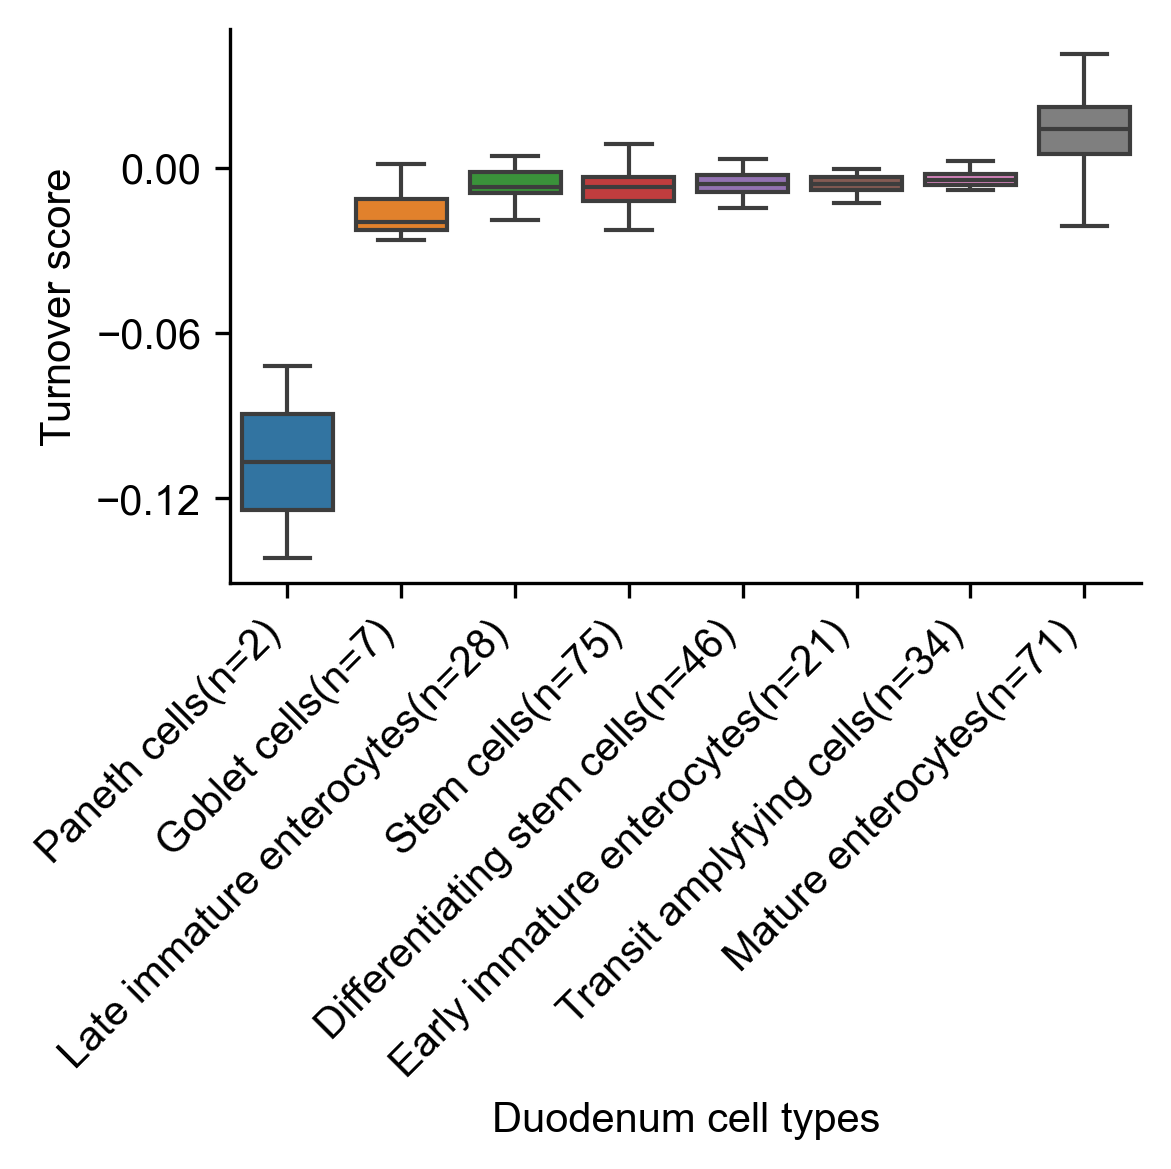

In [44]:
# Calculate the number of rows and columns needed for a square layout
# this is for the ###^^^^paper^^^^### figure
side_size = 4
use_field = "gross_cell_type"
representative_cell_types = dict()
representative_cell_types['esophagus'] = np.setdiff1d(organs_adatas['esophagus'].obs[use_field].unique(),'Immune_cells')
representative_cell_types['stomach'] = ['Differentiating_cells', 'Chief_cells', 'Mature_pit_cells', 'Prezymogenic_cells','Immature_pit_cells','Parietal_cells', 'Neck_cells','Isthmus_cells',"Endocrine_cells"]
representative_cell_types['duodenum'] = np.setdiff1d(organs_adatas['duodenum'].obs[use_field].unique(), ["Immune_cells","BCHE_cells", "Endocrine_D_cells"])

for my_organ,fig_letter in zip(organs_adatas.keys(),['e','f','g']):
    print(fig_letter + " " + my_organ)
    fig, ax = plt.subplots(1, 1, figsize=(side_size, side_size), dpi=300)
    cell_types = np.intersect1d(organs_adatas[my_organ].obs[use_field].unique(), representative_cell_types[my_organ])
    obs_to_fig = organs_adatas[my_organ].obs[organs_adatas[my_organ].obs[use_field].isin(cell_types)].copy()
    obs_to_fig[use_field] = obs_to_fig[use_field].cat.remove_unused_categories()

    cell_types = obs_to_fig[use_field].unique()
    cell_types_median = obs_to_fig.groupby(use_field)['shedding_score'].median()
    cell_types_ord = cell_types_median.sort_values().index.tolist()

    # count the number of cells within each cell type
    cell_counts = obs_to_fig[use_field].value_counts().reindex()


    sns.boxplot(data=obs_to_fig, x=use_field, y='shedding_score', order=cell_types_ord, ax=ax, showfliers=False, palette="tab10")
    # ax.axhline(0, color='black', linestyle='--', zorder=0)
    xticks_labels = [label.get_text() for label in plt.gca().get_xticklabels()]
    xticks_labels = [f"{label}(n={cell_counts[label]})" for label in xticks_labels]

    # ax.set_title(my_organ.capitalize())
    ax.spines[['right', 'top']].set_visible(False)
    # ax.set_xticklabels([label.replace('_', ' ') for label in cell_types_ord], rotation=45, ha='right')
    ax.set_xticklabels([label.replace('_', ' ') for label in xticks_labels], rotation=45, ha='right')
    ax.set_xlabel(my_organ.capitalize() + " cell types")
    ax.set_ylabel("Turnover score")
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    plt.tight_layout()
    plt.show()
    fig.savefig(PROJ_MAIN_FOLDER+"Fig3"+fig_letter+"_"+my_organ+".pdf", bbox_inches='tight')

In [45]:
print(datetime.now())

2025-08-19 17:10:34.157500
